In [1]:
import numpy as np
from scipy.spatial.distance import cdist

class gaussian_kde(object):
    """Representation of a kernel-density estimate using Gaussian kernels.

    Kernel density estimation is a way to estimate the probability density
    function (PDF) of a random variable in a non-parametric way.
    `gaussian_kde` works for both uni-variate and multi-variate data.   It
    includes automatic bandwidth determination.  The estimation works best for
    a unimodal distribution; bimodal or multi-modal distributions tend to be
    oversmoothed.

    Parameters
    ----------
    dataset : array_like
        Datapoints to estimate from. In case of univariate data this is a 1-D
        array, otherwise a 2-D array with shape (# of dims, # of data).
    bw_method : str, scalar or callable, optional
        The method used to calculate the estimator bandwidth.  This can be
        'scott', 'silverman', a scalar constant or a callable.  If a scalar,
        this will be used directly as `kde.factor`.  If a callable, it should
        take a `gaussian_kde` instance as only parameter and return a scalar.
        If None (default), 'scott' is used.  See Notes for more details.
    weights : array_like, shape (n, ), optional, default: None
        An array of weights, of the same shape as `x`.  Each value in `x`
        only contributes its associated weight towards the bin count
        (instead of 1).

    Attributes
    ----------
    dataset : ndarray
        The dataset with which `gaussian_kde` was initialized.
    d : int
        Number of dimensions.
    n : int
        Number of datapoints.
    neff : float
        Effective sample size using Kish's approximation.
    factor : float
        The bandwidth factor, obtained from `kde.covariance_factor`, with which
        the covariance matrix is multiplied.
    covariance : ndarray
        The covariance matrix of `dataset`, scaled by the calculated bandwidth
        (`kde.factor`).
    inv_cov : ndarray
        The inverse of `covariance`.

    Methods
    -------
    kde.evaluate(points) : ndarray
        Evaluate the estimated pdf on a provided set of points.
    kde(points) : ndarray
        Same as kde.evaluate(points)
    kde.pdf(points) : ndarray
        Alias for ``kde.evaluate(points)``.
    kde.set_bandwidth(bw_method='scott') : None
        Computes the bandwidth, i.e. the coefficient that multiplies the data
        covariance matrix to obtain the kernel covariance matrix.
        .. versionadded:: 0.11.0
    kde.covariance_factor : float
        Computes the coefficient (`kde.factor`) that multiplies the data
        covariance matrix to obtain the kernel covariance matrix.
        The default is `scotts_factor`.  A subclass can overwrite this method
        to provide a different method, or set it through a call to
        `kde.set_bandwidth`.

    Notes
    -----
    Bandwidth selection strongly influences the estimate obtained from the KDE
    (much more so than the actual shape of the kernel).  Bandwidth selection
    can be done by a "rule of thumb", by cross-validation, by "plug-in
    methods" or by other means; see [3]_, [4]_ for reviews.  `gaussian_kde`
    uses a rule of thumb, the default is Scott's Rule.

    Scott's Rule [1]_, implemented as `scotts_factor`, is::

        n**(-1./(d+4)),

    with ``n`` the number of data points and ``d`` the number of dimensions.
    Silverman's Rule [2]_, implemented as `silverman_factor`, is::

        (n * (d + 2) / 4.)**(-1. / (d + 4)).

    Good general descriptions of kernel density estimation can be found in [1]_
    and [2]_, the mathematics for this multi-dimensional implementation can be
    found in [1]_.

    References
    ----------
    .. [1] D.W. Scott, "Multivariate Density Estimation: Theory, Practice, and
           Visualization", John Wiley & Sons, New York, Chicester, 1992.
    .. [2] B.W. Silverman, "Density Estimation for Statistics and Data
           Analysis", Vol. 26, Monographs on Statistics and Applied Probability,
           Chapman and Hall, London, 1986.
    .. [3] B.A. Turlach, "Bandwidth Selection in Kernel Density Estimation: A
           Review", CORE and Institut de Statistique, Vol. 19, pp. 1-33, 1993.
    .. [4] D.M. Bashtannyk and R.J. Hyndman, "Bandwidth selection for kernel
           conditional density estimation", Computational Statistics & Data
           Analysis, Vol. 36, pp. 279-298, 2001.

    Examples
    --------
    Generate some random two-dimensional data:

    >>> from scipy import stats
    >>> def measure(n):
    >>>     "Measurement model, return two coupled measurements."
    >>>     m1 = np.random.normal(size=n)
    >>>     m2 = np.random.normal(scale=0.5, size=n)
    >>>     return m1+m2, m1-m2

    >>> m1, m2 = measure(2000)
    >>> xmin = m1.min()
    >>> xmax = m1.max()
    >>> ymin = m2.min()
    >>> ymax = m2.max()

    Perform a kernel density estimate on the data:

    >>> X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    >>> positions = np.vstack([X.ravel(), Y.ravel()])
    >>> values = np.vstack([m1, m2])
    >>> kernel = stats.gaussian_kde(values)
    >>> Z = np.reshape(kernel(positions).T, X.shape)

    Plot the results:

    >>> import matplotlib.pyplot as plt
    >>> fig = plt.figure()
    >>> ax = fig.add_subplot(111)
    >>> ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,
    ...           extent=[xmin, xmax, ymin, ymax])
    >>> ax.plot(m1, m2, 'k.', markersize=2)
    >>> ax.set_xlim([xmin, xmax])
    >>> ax.set_ylim([ymin, ymax])
    >>> plt.show()

    """
    def __init__(self, dataset, bw_method=None, weights=None):
        self.dataset = np.atleast_2d(dataset)
        if not self.dataset.size > 1:
            raise ValueError("`dataset` input should have multiple elements.")
        self.d, self.n = self.dataset.shape
            
        if weights is not None:
            self.weights = weights / np.sum(weights)
        else:
            self.weights = np.ones(self.n) / self.n
            
        # Compute the effective sample size 
        # http://surveyanalysis.org/wiki/Design_Effects_and_Effective_Sample_Size#Kish.27s_approximate_formula_for_computing_effective_sample_size
        self.neff = 1.0 / np.sum(self.weights ** 2)

        self.set_bandwidth(bw_method=bw_method)

    def evaluate(self, points):
        """Evaluate the estimated pdf on a set of points.

        Parameters
        ----------
        points : (# of dimensions, # of points)-array
            Alternatively, a (# of dimensions,) vector can be passed in and
            treated as a single point.

        Returns
        -------
        values : (# of points,)-array
            The values at each point.

        Raises
        ------
        ValueError : if the dimensionality of the input points is different than
                     the dimensionality of the KDE.

        """
        points = np.atleast_2d(points)

        d, m = points.shape
        if d != self.d:
            if d == 1 and m == self.d:
                # points was passed in as a row vector
                points = np.reshape(points, (self.d, 1))
                m = 1
            else:
                msg = "points have dimension %s, dataset has dimension %s" % (d,
                    self.d)
                raise ValueError(msg)

        # compute the normalised residuals
        chi2 = cdist(points.T, self.dataset.T, 'mahalanobis', VI=self.inv_cov) ** 2
        # compute the pdf
        result = np.sum(np.exp(-.5 * chi2) * self.weights, axis=1) / self._norm_factor

        return result

    __call__ = evaluate

    def scotts_factor(self):
        return np.power(self.neff, -1./(self.d+4))

    def silverman_factor(self):
        return np.power(self.neff*(self.d+2.0)/4.0, -1./(self.d+4))

    #  Default method to calculate bandwidth, can be overwritten by subclass
    covariance_factor = scotts_factor

    def set_bandwidth(self, bw_method=None):
        """Compute the estimator bandwidth with given method.

        The new bandwidth calculated after a call to `set_bandwidth` is used
        for subsequent evaluations of the estimated density.

        Parameters
        ----------
        bw_method : str, scalar or callable, optional
            The method used to calculate the estimator bandwidth.  This can be
            'scott', 'silverman', a scalar constant or a callable.  If a
            scalar, this will be used directly as `kde.factor`.  If a callable,
            it should take a `gaussian_kde` instance as only parameter and
            return a scalar.  If None (default), nothing happens; the current
            `kde.covariance_factor` method is kept.

        Notes
        -----
        .. versionadded:: 0.11

        Examples
        --------
        >>> x1 = np.array([-7, -5, 1, 4, 5.])
        >>> kde = stats.gaussian_kde(x1)
        >>> xs = np.linspace(-10, 10, num=50)
        >>> y1 = kde(xs)
        >>> kde.set_bandwidth(bw_method='silverman')
        >>> y2 = kde(xs)
        >>> kde.set_bandwidth(bw_method=kde.factor / 3.)
        >>> y3 = kde(xs)

        >>> fig = plt.figure()
        >>> ax = fig.add_subplot(111)
        >>> ax.plot(x1, np.ones(x1.shape) / (4. * x1.size), 'bo',
        ...         label='Data points (rescaled)')
        >>> ax.plot(xs, y1, label='Scott (default)')
        >>> ax.plot(xs, y2, label='Silverman')
        >>> ax.plot(xs, y3, label='Const (1/3 * Silverman)')
        >>> ax.legend()
        >>> plt.show()

        """
        if bw_method is None:
            pass
        elif bw_method == 'scott':
            self.covariance_factor = self.scotts_factor
        elif bw_method == 'silverman':
            self.covariance_factor = self.silverman_factor
        elif np.isscalar(bw_method) and not isinstance(bw_method, string_types):
            self._bw_method = 'use constant'
            self.covariance_factor = lambda: bw_method
        elif callable(bw_method):
            self._bw_method = bw_method
            self.covariance_factor = lambda: self._bw_method(self)
        else:
            msg = "`bw_method` should be 'scott', 'silverman', a scalar " \
                  "or a callable."
            raise ValueError(msg)

        self._compute_covariance()

    def _compute_covariance(self):
        """Computes the covariance matrix for each Gaussian kernel using
        covariance_factor().
        """
        self.factor = self.covariance_factor()
        # Cache covariance and inverse covariance of the data
        if not hasattr(self, '_data_inv_cov'):
            # Compute the mean and residuals
            _mean = np.sum(self.weights * self.dataset, axis=1)
            _residual = (self.dataset - _mean[:, None])
            # Compute the biased covariance
            self._data_covariance = np.atleast_2d(np.dot(_residual * self.weights, _residual.T))
            # Correct for bias (http://en.wikipedia.org/wiki/Weighted_arithmetic_mean#Weighted_sample_covariance)
            self._data_covariance /= (1 - np.sum(self.weights ** 2))
            self._data_inv_cov = np.linalg.inv(self._data_covariance)

        self.covariance = self._data_covariance * self.factor**2
        self.inv_cov = self._data_inv_cov / self.factor**2
        self._norm_factor = np.sqrt(np.linalg.det(2*np.pi*self.covariance)) #* self.n

# Unweighted test

Populating the interactive namespace from numpy and matplotlib


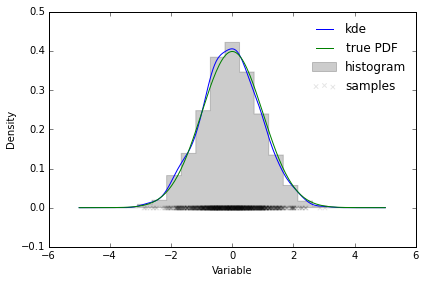

In [2]:
%pylab inline
import matplotlib.pyplot as plt
from scipy import stats

#Define parameters
num_samples = 1000
xmax = 5
bins=21

#Generate equal-weighted samples
samples = np.random.normal(size=num_samples)
weights = np.ones(num_samples) / num_samples

#Plot a histogram
plt.hist(samples, bins, (-xmax, xmax), histtype='stepfilled', 
         alpha=.2, normed=True, color='k', label='histogram')

#Construct a KDE and plot it
pdf = gaussian_kde(samples)
x = np.linspace(-xmax, xmax, 200)
y = pdf(x)
plt.plot(x, y, label='kde')

#Plot the samples
plt.scatter(samples, np.zeros_like(samples), marker='x', 
            color='k', alpha=.1, label='samples')

#Plot the true pdf
y = stats.norm().pdf(x)
plt.plot(x,y, label='true PDF')

#Boiler plate
plt.xlabel('Variable')
plt.ylabel('Density')
plt.legend(loc='best', frameon=False)
plt.tight_layout()
plt.show()

# Weighted test

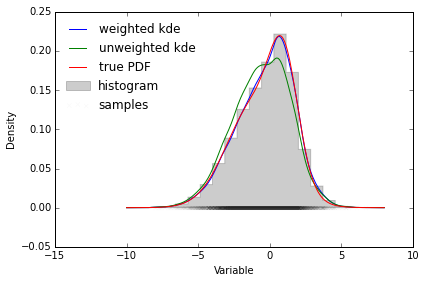

In [3]:
from scipy import stats

#Define a Gaussian mixture to draw samples from
num_samples = 10000
xmin, xmax = -10, 8
#Weight attributed to each component of the mixture
gaussian_weights = np.array([2, 1], dtype=np.float)
gaussian_weights /= np.sum(gaussian_weights)
#Mean and std of each mixture
gaussian_means = np.array([-1, 1])
gaussian_std = np.array([2, 1])
#Observation probability of each mixture
gaussian_observation = np.array([1, .5])

#How many samples belong to each mixture?
gaussian_samples = np.random.multinomial(num_samples, gaussian_weights)
samples = []
weights = []
#Generate samples and observed samples for each mixture component
for n, m, s, o in zip(gaussian_samples, gaussian_means, gaussian_std, gaussian_observation):
    _samples = np.random.normal(m, s, n)
    _samples = _samples[o > np.random.uniform(size=n)]
    samples.extend(_samples)
    weights.extend(np.ones_like(_samples) / o)

#Renormalise the sample weights
weights = np.array(weights, np.float)
weights /= np.sum(weights)
samples = np.array(samples)

#Compute the true pdf
x = np.linspace(xmin, xmax, 200)
true_pdf = 0
for w, m, s in zip(gaussian_weights, gaussian_means, gaussian_std):
    true_pdf = true_pdf + w * stats.norm(m, s).pdf(x)
    
#Plot a histogram
plt.hist(samples, bins, (xmin, xmax), histtype='stepfilled', 
         alpha=.2, normed=True, color='k', label='histogram', weights=weights)

#Construct a KDE and plot it
pdf = gaussian_kde(samples, weights=weights)
y = pdf(x)
plt.plot(x, y, label='weighted kde')

#Compare with a naive kde
pdf = stats.gaussian_kde(samples)
y = pdf(x)
plt.plot(x, y, label='unweighted kde')

#Plot the samples
plt.scatter(samples, np.zeros_like(samples), marker='x', 
            color='k', alpha=.02, label='samples')

#Plot the true pdf
plt.plot(x,true_pdf, label='true PDF')

#Boiler plate
plt.xlabel('Variable')
plt.ylabel('Density')
plt.legend(loc='best', frameon=False)
plt.tight_layout()
plt.show()

# 2D weighted test

In [4]:
from scipy import stats

#Define a Gaussian mixture to draw samples from
num_samples = 10000
xmin, xmax = -10, 8
#Weight attributed to each component of the mixture
gaussian_weights = np.array([2, 1], dtype=np.float)
gaussian_weights /= np.sum(gaussian_weights)
#Mean and std of each mixture
gaussian_means = np.array([-1, 1])
gaussian_std = np.array([2, 1])
#Observation probability of each mixture
gaussian_observation = np.array([1, .5])

#How many samples belong to each mixture?
gaussian_samples = np.random.multinomial(num_samples, gaussian_weights)
samples = []
weights = []
#Generate samples and observed samples for each mixture component
for n, m, s, o in zip(gaussian_samples, gaussian_means, gaussian_std, gaussian_observation):
    _samples = np.random.normal(m, s, (n, 2))
    _samples = _samples[o > np.random.uniform(size=n)]
    samples.extend(_samples)
    weights.extend(np.ones(len(_samples)) / o)

#Renormalise the sample weights
weights = np.array(weights, np.float)
weights /= np.sum(weights)
samples = np.transpose(samples)

In [5]:
#Evaluate the true pdf on a grid
x = np.linspace(xmin, xmax, 100)
xx, yy = np.meshgrid(x, x)
true_pdf = 0
for w, m, s in zip(gaussian_weights, gaussian_means, gaussian_std):
    true_pdf = true_pdf + w * stats.norm(m, s).pdf(xx) * stats.norm(m, s).pdf(yy)

In [6]:
#Evaluate the kde on a grid
pdf = gaussian_kde(samples, weights=weights)
zz = pdf((np.ravel(xx), np.ravel(yy)))
zz = np.reshape(zz, xx.shape)

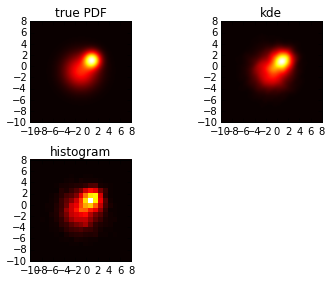

In [7]:
kwargs = dict(extent=(xmin, xmax, xmin, xmax), cmap='hot', origin='lower')
#Plot the true pdf
plt.subplot(221)
plt.imshow(true_pdf.T, **kwargs)
plt.title('true PDF')

#Plot the kde
plt.subplot(222)
plt.imshow(zz.T, **kwargs)
plt.title('kde')
plt.tight_layout()

#Plot a histogram
ax = plt.subplot(223)
plt.hist2d(samples[0], samples[1], bins, ((xmin, xmax), (xmin, xmax)), 
           True, weights, cmap='hot')
ax.set_aspect(1)
plt.title('histogram')
plt.tight_layout()
plt.show()